# HW7: PCA, LDA, Kernel PCA, Kernel LDA
@author: BAIM Mohamed Jalal, 313551810

In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
from tqdm import trange

In [2]:
def read_pmg(path):
    """
    Reads a PGM (Portable GrayMap) image from the given path.
    Returns the image as a 1D NumPy array of pixel intensities.
    """
    with open(path, 'rb') as f:
        assert f.readline() == b'P5\n', "Not a valid P5 PGM file!"
        f.readline()  # comment line (could check or skip safely)
        width, height = [int(i) for i in f.readline().split()]
        max_val = int(f.readline())  # e.g. 255
        assert max_val <= 255, "Only 8-bit PGM images are supported."
        
        img = np.zeros((height, width), dtype=np.uint8)
        for row in range(height):
            for col in range(width):
                img[row, col] = ord(f.read(1))

    return img.reshape(-1)

def load_images(folder_path):
    """
    Loads all PGM images from folder_path.
    Returns:
        - images: shape (num_samples, num_pixels)
        - filenames: list of filenames without extension
        - labels: extracted from filename convention
    """
    images = []
    filenames = []
    labels = []

    for file_name in os.listdir(folder_path):
        if file_name.lower().endswith('.pgm'):
            data = read_pmg(os.path.join(folder_path, file_name))
            images.append(data)
            # Extract label from naming convention 'subjectXX.something'
            base_name = os.path.splitext(file_name)[0]
            # Example: 'subject01.wink' -> label is '01'
            label = int(base_name[7:9])  # you can adapt if your naming is different
            filenames.append(base_name)
            labels.append(label)

    images = np.array(images, dtype=np.float64)
    labels = np.array(labels, dtype=np.int32)
    return images, filenames, labels

def resize_images(images, original_shape=(195, 231), target_shape=(65, 77)):
    """
    Simple block-downsampling approach:
    original_shape = (width=195, height=231)
    target_shape = (width=65, height=77)
    
    For each 3x3 block in original, average to 1 pixel in the resized image.
    Returns the resized images of shape (num_samples, target_height*target_width).
    """
    num_images = images.shape[0]
    (orig_w, orig_h) = original_shape
    (new_w, new_h) = target_shape
    
    resized = np.zeros((num_images, new_w * new_h), dtype=np.float64)
    
    for idx in range(num_images):
        img_2d = images[idx].reshape(orig_h, orig_w)
        temp = np.zeros((new_h, new_w), dtype=np.float64)

        # We'll just assume each dimension is a multiple of 3
        for row in range(new_h):
            for col in range(new_w):
                block = img_2d[row*3:row*3+3, col*3:col*3+3]
                temp[row, col] = np.mean(block)
        
        resized[idx] = temp.flatten()
    return resized

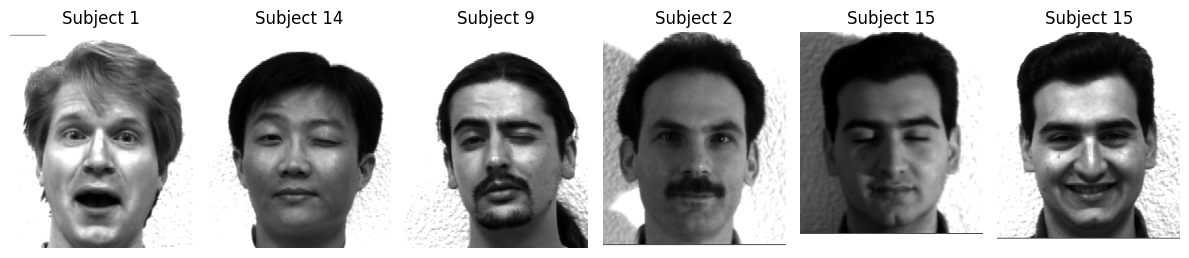

In [3]:
# Example usage:
TRAINING_PATH = "/kaggle/input/yale-face-data/Yale_Face_Database/Training"
TESTING_PATH = "/kaggle/input/yale-face-data/Yale_Face_Database/Testing"

train_data, train_fnames, train_labels = load_images(TRAINING_PATH)
test_data, test_fnames, test_labels = load_images(TESTING_PATH)

# Resize images to 77x65 (original 231x195, 3x3 compression)
train_resized = resize_images(train_data, original_shape=(195, 231), target_shape=(65, 77))
test_resized = resize_images(test_data, original_shape=(195, 231), target_shape=(65, 77))

# train_resized = train_data
# test_resized = test_data

# Let's choose a few random indices to visualize
num_images_to_display = 6
random_indices = np.random.choice(range(train_data.shape[0]), num_images_to_display, replace=False)

fig, axs = plt.subplots(1, num_images_to_display, figsize=(12, 4))
for i, idx in enumerate(random_indices):
    # Reshape the 1D array (231*195) back to (231, 195)
    img_2d = train_data[idx].reshape(231, 195)
    
    axs[i].imshow(img_2d, cmap='gray')
    axs[i].axis('off')  # remove the axis
    axs[i].set_title(f"Subject {train_labels[idx]}")

plt.tight_layout()
plt.show()

In [4]:
def pca(data, n_components=25):
    """
    PCA on data using the covariance matrix.
    data shape: (num_samples, num_features)
    Returns:
        - W: projection matrix of shape (num_features, n_components)
        - mean: the mean of the training data (shape: (num_features,))
    """
    # 1) Compute the mean and center the data
    mean = np.mean(data, axis=0)
    X_centered = data - mean
    
    # 2) Compute covariance
    covariance = np.cov(X_centered, rowvar=False)  # shape: (num_features, num_features)
    
    # 3) Eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(covariance)
    
    # 4) Sort by decreasing eigenvalue
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # 5) Take the top n_components
    W = eigenvectors[:, :n_components]
    
    # 6) Normalize each eigenvector (optional)
    for i in range(W.shape[1]):
        norm = np.linalg.norm(W[:, i])
        if norm > 1e-12:
            W[:, i] /= norm
    
    return W, mean

def lda(data, labels, n_components=25):
    """
    Fisher LDA on data using within-class and between-class scatter.
    data shape: (num_samples, num_features)
    labels shape: (num_samples,)
    Returns:
        - W: projection matrix of shape (num_features, n_components)
        - mean: the mean of the training data (shape: (num_features,))
    """
    # 1) Compute the global mean and center the data
    mean = np.mean(data, axis=0)
    X_centered = data - mean
    
    classes = np.unique(labels)
    num_features = data.shape[1]
    
    # Within-class scatter
    S_w = np.zeros((num_features, num_features), dtype=np.float64)
    # Between-class scatter
    S_b = np.zeros((num_features, num_features), dtype=np.float64)
    
    mean_global = np.mean(X_centered, axis=0)  # Mean of the centered data is 0 if we use X_centered
                                              # but to keep it explicit, we re-compute from X_centered

    for c in classes:
        X_c = X_centered[labels == c]
        mean_c = np.mean(X_c, axis=0)
        
        # Within-class scatter
        X_c_centered = X_c - mean_c
        S_w += X_c_centered.T @ X_c_centered
        
        # Between-class scatter
        diff = (mean_c - mean_global).reshape(-1, 1)
        S_b += X_c.shape[0] * (diff @ diff.T)
    
    # Solve for S_w^-1 * S_b
    S_w_inv = np.linalg.pinv(S_w)  # pseudo-inverse for numerical stability
    mat = S_w_inv @ S_b
    
    eigenvalues, eigenvectors = np.linalg.eigh(mat)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, idx]
    
    W = eigenvectors[:, :n_components]
    
    # Normalize each component
    for i in range(W.shape[1]):
        norm = np.linalg.norm(W[:, i])
        if norm > 1e-12:
            W[:, i] /= norm

    return W, mean

def linear_kernel(X, Y):
    """ K(x,y) = x · y """
    return X @ Y.T

def rbf_kernel(X, Y, gamma=1e-10):
    """ K(x,y) = exp(-gamma * ||x - y||^2) """
    X2 = np.sum(X**2, axis=1).reshape(-1, 1)
    Y2 = np.sum(Y**2, axis=1).reshape(1, -1)
    dist = X2 + Y2 - 2 * (X @ Y.T)
    return np.exp(-gamma * dist)

def kernel_pca(data, n_components=25, kernel_type='rbf'):
    """
    Kernel PCA on data, centering the data in the original input space first,
    then centering the kernel matrix in feature space.
    Returns:
        - W: eigenvectors in feature (kernel) space
        - K_centered: the centered kernel matrix for training
        - mean_data: the mean of the original training data
    """
    # 1) Center data in the original space
    mean_data = np.mean(data, axis=0)
    X_centered = data - mean_data
    
    # 2) Compute the kernel on the centered data
    if kernel_type == 'linear':
        K = linear_kernel(X_centered, X_centered)
    elif kernel_type == 'rbf':
        K = rbf_kernel(X_centered, X_centered)
    else:
        raise ValueError("Unsupported kernel type. Choose 'linear' or 'rbf'.")

    # 3) Center the kernel matrix in feature space
    n_samples = K.shape[0]
    one_n = np.ones((n_samples, n_samples)) / n_samples
    K_centered = K

    # 4) Eigen-decomposition of the centered kernel
    eigenvalues, eigenvectors = np.linalg.eigh(K_centered)

    # 5) Sort eigenvalues (and eigenvectors) in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # 6) Select the top n_components
    W = eigenvectors[:, :n_components]

    # 7) Normalize each eigenvector in kernel space
    for i in range(W.shape[1]):
        norm_val = np.linalg.norm(W[:, i])
        if norm_val > 1e-12:
            W[:, i] /= norm_val

    return W, K_centered, mean_data


def kernel_lda(data, labels, n_components=25, kernel_type='rbf'):
    """
    Kernel LDA (toy version) with data centered in the original space, then
    constructing S_w and S_b in kernel (feature) space via matrix Z instead
    of explicit class scatter. This ignores `labels` for S_w/S_b construction.
    
    Returns:
        - W: eigenvectors in the kernel (feature) space
        - K_centered: the centered kernel matrix for training
        - mean_data: the mean of the original training data
    """
    # 1) Center the data in the original space
    mean_data = np.mean(data, axis=0)
    X_centered = data - mean_data

    # 2) Compute the kernel on the centered data
    if kernel_type == 'rbf':
        K = rbf_kernel(X_centered, X_centered)
    elif kernel_type == 'linear':
        K = linear_kernel(X_centered, X_centered)
    else:
        raise ValueError("Unsupported kernel type. Choose 'linear' or 'rbf'.")

    # 3) center the kernel matrix in feature space
    n_samples = K.shape[0]
    K_centered = K

    # 4) Construct S_w and S_b using the matrix Z
    S_w = K_centered @ K_centered
    Z = np.ones((n_samples, n_samples)) / (n_samples**2)
    S_b = K_centered @ Z @ K_centered

    # 5) Solve the generalized eigenvalue problem S_w^-1 * S_b
    S_w_inv = np.linalg.pinv(S_w)  # pseudo-inverse if S_w is singular
    mat = S_w_inv @ S_b
    eigenvalues, eigenvectors = np.linalg.eigh(mat)

    # 6) Sort eigenvalues in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, idx]

    # 7) Select top n_components and normalize columns
    W = eigenvectors[:, :n_components]
    for i in range(W.shape[1]):
        norm_val = np.linalg.norm(W[:, i])
        if norm_val > 1e-12:
            W[:, i] /= norm_val

    return W, K_centered, mean_data

In [5]:
def plot_eigenvectors(W, image_shape=(77, 65), title_prefix='Eigen'):
    """
    Plots the columns of W as images (assuming each column is a flattened 2D image).
    """
    num_vectors = W.shape[1]
    fig = plt.figure(figsize=(8, 8))
    grid_size = int(np.ceil(np.sqrt(num_vectors)))

    for i in range(num_vectors):
        ax = fig.add_subplot(grid_size, grid_size, i + 1)
        ax.axis('off')
        ax.imshow(W[:, i].reshape(image_shape), cmap='gray')
    
    fig.suptitle(f"{title_prefix} Faces", fontsize=16)
    plt.show()

def reconstruct_random_faces(W, data, mean=None, image_shape=(77, 65), n_samples=5, title_prefix='Reconstruction'):
    """
    Reconstruct random faces using a linear subspace W.
    - If mean is provided, we subtract it (center) before projecting,
      then add it back after reconstruction.
    """
    idx = np.random.choice(data.shape[0], n_samples, replace=False)
    fig = plt.figure(figsize=(2*n_samples, 4))

    for i in range(n_samples):
        ax_orig = fig.add_subplot(2, n_samples, i+1)
        ax_recon = fig.add_subplot(2, n_samples, i+1+n_samples)

        # Original
        original_2d = data[idx[i]].reshape(image_shape)
        ax_orig.imshow(original_2d, cmap='gray')
        ax_orig.axis('off')
        ax_orig.set_title("Original")

        # Reconstruct
        x = data[idx[i]]
        if mean is not None:
            x = x - mean  # center

        # Project then reconstruct
        x_proj = x @ W
        x_recon = x_proj @ W.T

        if mean is not None:
            x_recon = x_recon + mean  # un-center

        x_recon_2d = x_recon.reshape(image_shape)
        ax_recon.imshow(x_recon_2d, cmap='gray')
        ax_recon.axis('off')
        ax_recon.set_title("Reconstruction")

    fig.suptitle(title_prefix, fontsize=16)
    plt.show()

In [6]:
def predict_nearest_neighbor(train_data, train_labels, test_data, test_labels, 
                             W, mean=None, k=5):
    """
    k-NN prediction in the (linear) projected subspace.
    - If mean is provided, both train_data and test_data get centered before projection.
    """
    # 1) Project train set
    if mean is not None:
        X_train = (train_data - mean) @ W
        X_test = (test_data - mean) @ W
    else:
        X_train = train_data @ W
        X_test = test_data @ W

    # 2) k-NN classification
    error = 0
    for i in range(len(test_data)):
        dists = np.sum((X_test[i] - X_train)**2, axis=1)
        nn_idx = np.argsort(dists)[:k]  # indices of the k nearest neighbors
        predicted_label = np.argmax(np.bincount(train_labels[nn_idx]))
        if predicted_label != test_labels[i]:
            error += 1

    error_rate = 100.0 * error / len(test_data)
    print(f"k= {k}, Error rate: {error_rate:.2f}%")
    return error_rate


def predict_kernel_nearest_neighbor(train_data, train_labels, test_data, test_labels,
                                   W, K_train, mean_data=None, kernel_type='rbf', k=5):
    """
    k-NN prediction in the kernel (feature) subspace.
    - We must center test_data in the same way as train_data,
      then build the test-vs-train kernel from the centered data.
    """
    # 1) Center the test data in input space (using training mean)
    if mean_data is not None:
        test_data_centered = test_data - mean_data
        train_data_centered = train_data - mean_data
    else:
        test_data_centered = test_data
        train_data_centered = train_data

    # 2) Build K_test from the (centered) test data vs (centered) train data
    if kernel_type == 'rbf':
        K_test = rbf_kernel(test_data_centered, train_data_centered)
    elif kernel_type == 'linear':
        K_test = linear_kernel(test_data_centered, train_data_centered)
    else:
        raise ValueError("Unsupported kernel type.")

    # 3) Project training and testing kernel onto W
    X_train = K_train @ W
    X_test = K_test @ W

    # 4) k-NN classification
    error = 0
    for i in range(len(test_data)):
        dists = np.sum((X_test[i] - X_train)**2, axis=1)
        nn_idx = np.argsort(dists)[:k]
        predicted_label = np.argmax(np.bincount(train_labels[nn_idx]))
        if predicted_label != test_labels[i]:
            error += 1

    error_rate = 100.0 * error / len(test_data)
    print(f"[Kernel {kernel_type}, k={k}] Error rate: {error_rate:.2f}% Accuracy: {100 - error_rate:.2f}%")
    return error_rate

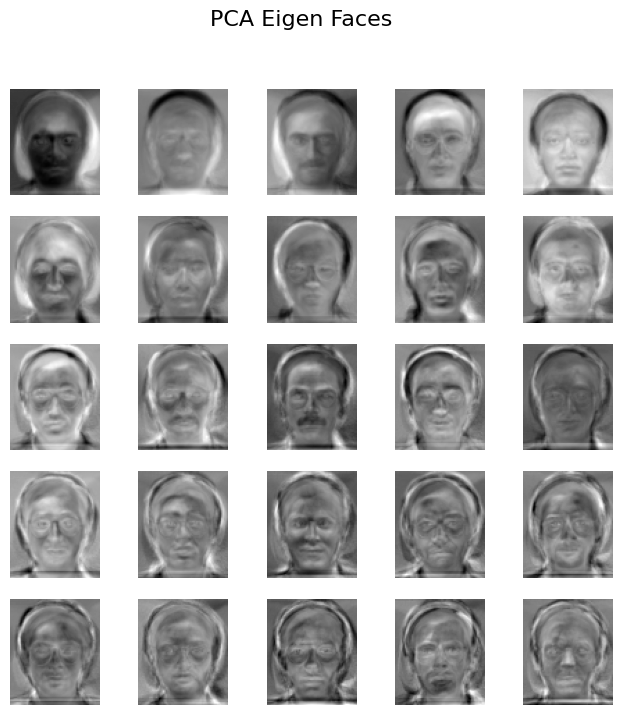

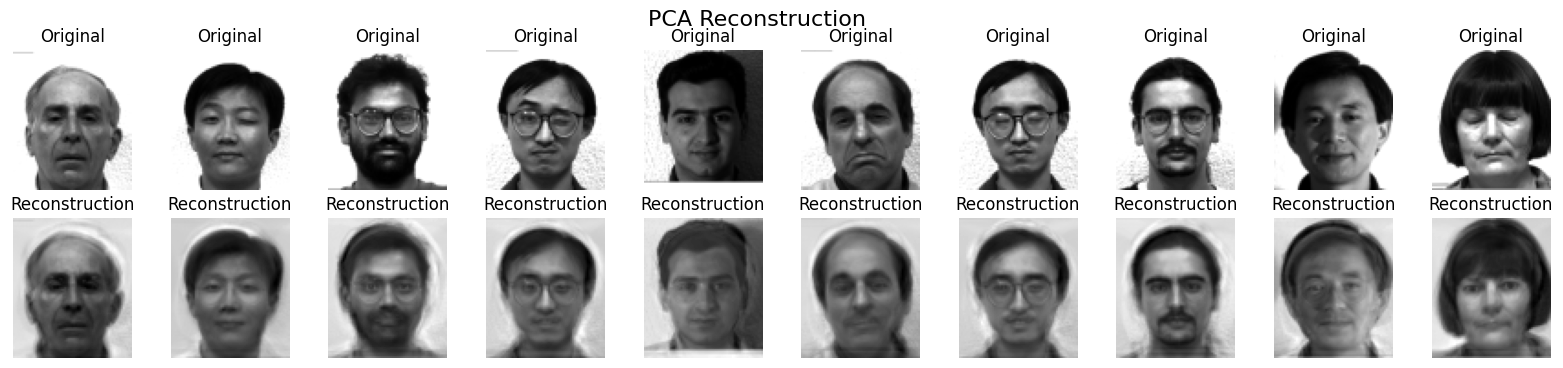

For k = 1 :
k= 1, Error rate: 16.67%
For k = 2 :
k= 2, Error rate: 16.67%
For k = 3 :
k= 3, Error rate: 16.67%
For k = 4 :
k= 4, Error rate: 16.67%
For k = 5 :
k= 5, Error rate: 10.00%


In [7]:
# PCA
W_pca, mean_pca = pca(train_resized, n_components=25)

# Visualization
plot_eigenvectors(W_pca, image_shape=(77, 65), title_prefix='PCA Eigen')

# Reconstruction
reconstruct_random_faces(W_pca, train_resized, mean=mean_pca, image_shape=(77, 65),
                         n_samples=10, title_prefix='PCA Reconstruction')

# Prediction
for K in range(1,6):
    print(f"For k = {K} :")
    _ = predict_nearest_neighbor(train_resized, train_labels, test_resized, test_labels,
                                 W_pca, k=K)

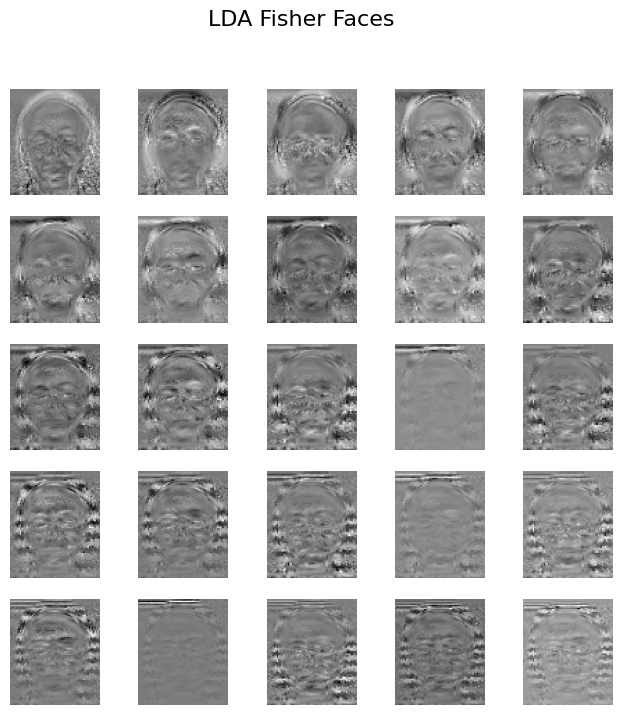

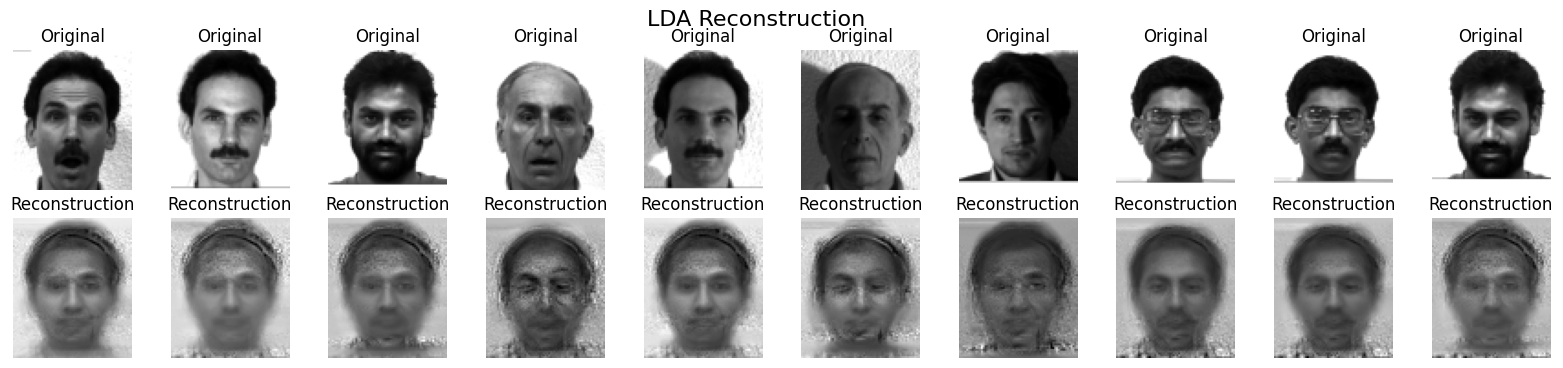

For 1 :
k= 1, Error rate: 16.67%
For 2 :
k= 2, Error rate: 23.33%
For 3 :
k= 3, Error rate: 16.67%
For 4 :
k= 4, Error rate: 13.33%
For 5 :
k= 5, Error rate: 16.67%


In [8]:
# LDA
W_lda, mean_lda = lda(train_resized, train_labels, n_components=25)

# Visualization
plot_eigenvectors(W_lda, image_shape=(77, 65), title_prefix='LDA Fisher')

# Reconstruction
reconstruct_random_faces(W_lda, train_resized, mean=mean_lda,
                         image_shape=(77, 65), n_samples=10,
                         title_prefix='LDA Reconstruction')

# Prediction
for K in range(1,6):
    print(f"For {K} :")
    _ = predict_nearest_neighbor(train_resized, train_labels,
                             test_resized, test_labels, W_lda, mean=mean_lda, k=K)

In [9]:
# Kernel PCA
kernels = ["rbf", "linear"]
for K in range(1,6):
    for kernel in kernels:
        W_kpca, K_train_centered, mean_kpca = kernel_pca(train_data, 
                                                         n_components=25, 
                                                         kernel_type= kernel)
        
        train_data_centered = train_data - mean_kpca
        test_data_centered = test_data - mean_kpca
        
        _ = predict_kernel_nearest_neighbor(
                train_data, train_labels,
                test_data, test_labels,
                W_kpca, K_train_centered,
                mean_data=mean_kpca,
                kernel_type=kernel, k=K
        )

[Kernel rbf, k=1] Error rate: 16.67% Accuracy: 83.33%
[Kernel linear, k=1] Error rate: 20.00% Accuracy: 80.00%
[Kernel rbf, k=2] Error rate: 23.33% Accuracy: 76.67%
[Kernel linear, k=2] Error rate: 20.00% Accuracy: 80.00%
[Kernel rbf, k=3] Error rate: 23.33% Accuracy: 76.67%
[Kernel linear, k=3] Error rate: 16.67% Accuracy: 83.33%
[Kernel rbf, k=4] Error rate: 20.00% Accuracy: 80.00%
[Kernel linear, k=4] Error rate: 16.67% Accuracy: 83.33%
[Kernel rbf, k=5] Error rate: 20.00% Accuracy: 80.00%
[Kernel linear, k=5] Error rate: 16.67% Accuracy: 83.33%


In [10]:
# Kernel LDA
kernels = ["rbf", "linear"]

for K in range(1,6):
    for kernel in kernels:
        W_klda, K_train_lda_centered, mean_klda = kernel_lda(
            data=train_data,
            labels=train_labels,
            n_components=25,
            kernel_type=  kernel
        )
        
        _ = predict_kernel_nearest_neighbor(
            train_data, train_labels,
            test_data, test_labels,
            W_klda, K_train_lda_centered,
            mean_data=mean_klda,
            kernel_type=kernel, k=K
        )

[Kernel rbf, k=1] Error rate: 26.67% Accuracy: 73.33%
[Kernel linear, k=1] Error rate: 23.33% Accuracy: 76.67%
[Kernel rbf, k=2] Error rate: 26.67% Accuracy: 73.33%
[Kernel linear, k=2] Error rate: 26.67% Accuracy: 73.33%
[Kernel rbf, k=3] Error rate: 26.67% Accuracy: 73.33%
[Kernel linear, k=3] Error rate: 20.00% Accuracy: 80.00%
[Kernel rbf, k=4] Error rate: 30.00% Accuracy: 70.00%
[Kernel linear, k=4] Error rate: 20.00% Accuracy: 80.00%
[Kernel rbf, k=5] Error rate: 33.33% Accuracy: 66.67%
[Kernel linear, k=5] Error rate: 23.33% Accuracy: 76.67%
